While pytorch is primarily used for neural networks, it is very good at solving a wider variety of nonlinear optimization problems with large numbers of parameters and/or large datasets. (If your problem has a closed form solution (e.g., linear regression), is a standard machine learning method, or operates on a small data set with a small number of parameters, you're probably better off using a different python library, such as [scikit-learn](https://scikit-learn.org/stable/index.html) or [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)).

Pytorch is so powerful for these tools because it has automatic differentiation built into it. When solving optimization problems, you need to know the gradient, understanding how the output of a model changes as you vary the input. This requires differentiating your model and in the olden days, this calculus would all have to be done by hand. Automatic differentiation (which is also present in other libraries, like tensorflow) means that your code will do the calculus for you: as long as your model and problem are written completely in pytorch, it can compute the gradient automatically. Note this restriction though: *every part* of the problem has to be written in pytorch. You can't mix `numpy` or `scikit-learn` in with the pytorch in your model code. In practice, this means that much of what you write will start with `torch.` instead of `np.`; fortunately, pytorch is robust enough now that pretty much any computation you wish to perform can be done in pytorch.

In the following example, we'll walk through the use of pytorch to fit a simple model of spatial frequency tuning across multiple voxels, like in my [recent paper](https://jov.arvojournals.org/article.aspx?articleid=2778653) ([github repo](https://github.com/billbrod/spatial-frequency-preferences)).

We will start by simulating and then fitting the data from a single voxel, before looking into how pytorch can easily handle the multi-voxel case.

In [1]:
# to install these, run `pip install tqdm torch matplotlib`

import matplotlib.pyplot as plt
import torch
# if you get errors with the progress bars, it means there's a problem with your
# installation of ipywidgets: https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-in-jupyterlab-3-0
from tqdm.auto import tqdm


%matplotlib inline

For model fitting in pytorch, we need several components:
1. Input data
2. Output data
3. The model, which accepts the input data, returns predictions for the output data, and has some parameters which dictate how this happens
4. An objective function, which tells us how good our predictions are
5. An optimizer, which knows how to update the model's parameters in order to minimize the objective function
6. A training loop, where we actually try to fit the parameters

this is a basic example with linear regression (pytorch is overkill for this and, as we'll see, actually doesn't do that good of a job here)

Let's start with the input data:

In [2]:
x = torch.logspace(-2, 1, 100)

We can think of a tensor like an array: it's n-dimensional and holds numbers.

In [3]:
x

tensor([1.0000e-02, 1.0723e-02, 1.1498e-02, 1.2328e-02, 1.3219e-02, 1.4175e-02,
        1.5199e-02, 1.6298e-02, 1.7475e-02, 1.8738e-02, 2.0092e-02, 2.1544e-02,
        2.3101e-02, 2.4771e-02, 2.6561e-02, 2.8480e-02, 3.0539e-02, 3.2745e-02,
        3.5112e-02, 3.7649e-02, 4.0370e-02, 4.3288e-02, 4.6416e-02, 4.9770e-02,
        5.3367e-02, 5.7224e-02, 6.1359e-02, 6.5793e-02, 7.0548e-02, 7.5646e-02,
        8.1113e-02, 8.6975e-02, 9.3260e-02, 1.0000e-01, 1.0723e-01, 1.1498e-01,
        1.2328e-01, 1.3219e-01, 1.4175e-01, 1.5199e-01, 1.6298e-01, 1.7475e-01,
        1.8738e-01, 2.0092e-01, 2.1544e-01, 2.3101e-01, 2.4771e-01, 2.6561e-01,
        2.8480e-01, 3.0539e-01, 3.2745e-01, 3.5112e-01, 3.7649e-01, 4.0370e-01,
        4.3288e-01, 4.6416e-01, 4.9770e-01, 5.3367e-01, 5.7224e-01, 6.1359e-01,
        6.5793e-01, 7.0548e-01, 7.5646e-01, 8.1113e-01, 8.6975e-01, 9.3260e-01,
        1.0000e+00, 1.0723e+00, 1.1498e+00, 1.2328e+00, 1.3219e+00, 1.4175e+00,
        1.5199e+00, 1.6298e+00, 1.7475e+

Let's simulate our output data. For that, we'll need our tuning curve. Let's use a simple three parameter log-Gaussian. Note how all the computations start with `torch.`! The exception is the basic arithmetic expressions (e.g., `**`, `-`), which get implicitly converted to the torch versions.

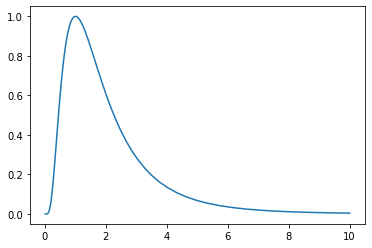

In [4]:
def log_gauss(x, amplitude=1, mode=1, sigma=1):
    # everything has to be a tensor
    if not isinstance(amplitude, torch.Tensor):
        amplitude = torch.tensor(amplitude)
    if not isinstance(sigma, torch.Tensor):
        sigma = torch.tensor(sigma)
    if not isinstance(mode, torch.Tensor):
        mode = torch.tensor(mode)
    return amplitude * torch.exp(-((torch.log2(x) - torch.log2(mode))**2) / (2*sigma**2))

plt.plot(x, log_gauss(x))

Now for our simulated output data, we'll take some random parameters (from uniform distribution between 0 and 3) and generate the responses from the tuning curve. For learning the basics, we won't add any noise -- in this case, we should be able to fit the data perfectly.

In [5]:
amplitude, mode, sigma = 3*torch.rand(3)
print(f'{amplitude=}, {mode=}, {sigma=}')

amplitude=tensor(2.9799), mode=tensor(0.3329), sigma=tensor(0.4917)


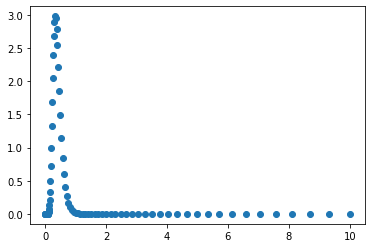

In [6]:
y = log_gauss(x, amplitude, mode, sigma)
plt.scatter(x, y)

Now, let's create our model. The model will transform the input data to the output data, based on some parameters. It will look a lot like the code we used to simulate the data. That's good! In general, a model like this is a generative model, and can be easily used to simulate data. Doing so is a good idea -- you can use simulated data to check that your training procedure is working, which is especially important when you're working with a new or complicated model.

We could make our model a function or series of functions, but our life will be easier if we use objects (see [this](https://www.codecademy.com/learn/learn-python/modules/learn-python-introduction-to-classes-u) for more about classes in python).

For our purposes, models should:
1. inherit `torch.nn.Module`
2. have an `__init__` method which initializes the object
3. have a `forward` method which tells you how to transform the input to the output

In [7]:
# pretty much any method you write should have `self` as its first argument (see the course above for why and when you would not want to do that).
class SingleVoxelTuning(torch.nn.Module):
    def __init__(self):
        # this runs the initialization code for torch.nn.Module, which sets up a bunch of stuff.
        super().__init__()
        # by marking something as a parameter, we're making it clear that this is what we want to update.
        # By using `self.` here, these parameters will be attached to the particular instance of the model,
        # allowing us to access them later, both within methods and as a user.
        self.amplitude = torch.nn.Parameter(torch.rand(1, dtype=torch.float32))
        self.mode = torch.nn.Parameter(torch.rand(1, dtype=torch.float32))
        self.sigma = torch.nn.Parameter(torch.rand(1, dtype=torch.float32))
        # we could allow the user to set initial values for these parameters, but setting random values is generally a good idea.
        # you'll want to train your model multiple times, and you want to see that you find a good solution no matter what parameter values you start with.
        # when you're finishing up your project and getting ready to share it, you can set the seeds of the random number generators 
        # (with both `np.random.seed` and `torch.manual_seed`) to make your results reproducible.

    def forward(self, x):
        return log_gauss(x, self.amplitude, self.mode, self.sigma)

This is how you create an instance of our general class above.

In [22]:
voxel = SingleVoxelTuning()

Calling `voxel(x)` is the same as calling `voxel.forward(x)` (I think this is only true if we've inherited `torch.nn.Module`). In either case, they turn the input data into the output.

In [23]:
print(voxel(x))
voxel.forward(x)

tensor([1.6235e-08, 3.5046e-08, 7.4387e-08, 1.5524e-07, 3.1856e-07, 6.4272e-07,
        1.2750e-06, 2.4869e-06, 4.7694e-06, 8.9935e-06, 1.6674e-05, 3.0397e-05,
        5.4484e-05, 9.6021e-05, 1.6639e-04, 2.8349e-04, 4.7490e-04, 7.8223e-04,
        1.2668e-03, 2.0173e-03, 3.1584e-03, 4.8622e-03, 7.3596e-03, 1.0953e-02,
        1.6028e-02, 2.3060e-02, 3.2622e-02, 4.5376e-02, 6.2057e-02, 8.3449e-02,
        1.1033e-01, 1.4343e-01, 1.8334e-01, 2.3041e-01, 2.8472e-01, 3.4594e-01,
        4.1327e-01, 4.8543e-01, 5.6063e-01, 6.3662e-01, 7.1080e-01, 7.8032e-01,
        8.4227e-01, 8.9391e-01, 9.3281e-01, 9.5708e-01, 9.6552e-01, 9.5771e-01,
        9.3404e-01, 8.9569e-01, 8.4451e-01, 7.8290e-01, 7.1363e-01, 6.3958e-01,
        5.6360e-01, 4.8833e-01, 4.1601e-01, 3.4847e-01, 2.8699e-01, 2.3240e-01,
        1.8504e-01, 1.4486e-01, 1.1151e-01, 8.4392e-02, 6.2801e-02, 4.5950e-02,
        3.3057e-02, 2.3383e-02, 1.6263e-02, 1.1121e-02, 7.4774e-03, 4.9433e-03,
        3.2132e-03, 2.0536e-03, 1.2905e-

tensor([1.6235e-08, 3.5046e-08, 7.4387e-08, 1.5524e-07, 3.1856e-07, 6.4272e-07,
        1.2750e-06, 2.4869e-06, 4.7694e-06, 8.9935e-06, 1.6674e-05, 3.0397e-05,
        5.4484e-05, 9.6021e-05, 1.6639e-04, 2.8349e-04, 4.7490e-04, 7.8223e-04,
        1.2668e-03, 2.0173e-03, 3.1584e-03, 4.8622e-03, 7.3596e-03, 1.0953e-02,
        1.6028e-02, 2.3060e-02, 3.2622e-02, 4.5376e-02, 6.2057e-02, 8.3449e-02,
        1.1033e-01, 1.4343e-01, 1.8334e-01, 2.3041e-01, 2.8472e-01, 3.4594e-01,
        4.1327e-01, 4.8543e-01, 5.6063e-01, 6.3662e-01, 7.1080e-01, 7.8032e-01,
        8.4227e-01, 8.9391e-01, 9.3281e-01, 9.5708e-01, 9.6552e-01, 9.5771e-01,
        9.3404e-01, 8.9569e-01, 8.4451e-01, 7.8290e-01, 7.1363e-01, 6.3958e-01,
        5.6360e-01, 4.8833e-01, 4.1601e-01, 3.4847e-01, 2.8699e-01, 2.3240e-01,
        1.8504e-01, 1.4486e-01, 1.1151e-01, 8.4392e-02, 6.2801e-02, 4.5950e-02,
        3.3057e-02, 2.3383e-02, 1.6263e-02, 1.1121e-02, 7.4774e-03, 4.9433e-03,
        3.2132e-03, 2.0536e-03, 1.2905e-

Most functions that accept numpy arrays can also accept tensors, but if the tensor have a gradient attached we have to call `.detach()` first or the function will yell at you. We can tell that `voxel(x)` has a gradient attached because of the `grad_fn=<MulBackwards0>` above. Generally, anything that has interacted with a `torch.nn.Parameter` will have a gradient attached

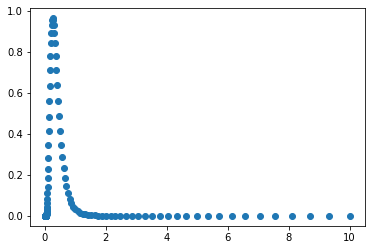

In [24]:
plt.scatter(x, voxel(x).detach())

This model was initialized with some random parameter values. We can examine these values whenever we like:

In [25]:
voxel.amplitude

Parameter containing:
tensor([0.9655], requires_grad=True)

We can use `voxel.named_parameters()` to see all of them at once:

In [26]:
list(voxel.named_parameters())

[('amplitude',
  Parameter containing:
  tensor([0.9655], requires_grad=True)),
 ('mode',
  Parameter containing:
  tensor([0.2480], requires_grad=True)),
 ('sigma',
  Parameter containing:
  tensor([0.7742], requires_grad=True))]

Over the course of learning, these parameters will change, as pytorch attempts to find the values that reduce the objective function as much as possible.

That means our objective function is pretty important! So let's define it. For now, let's just use mean-squared error:

In [13]:
def obj_func(x, y):
    # we have to use torch.mean (instead of np.mean) but the basic arithmetic symbols (-, +, **, etc) are all fine
    return torch.mean((x-y)**2)

Objective functions should accept your output data and your prediction, and return a scalar. They tell you how *bad* your prediction is -- the lower the number, the better.

You should write them so they don't make assumptions about the shape of the data they accept, so you can reuse them, and rely on functions like `torch.mean`, `torch.sum`, etc to combine them into a single value

In [14]:
obj_func(y, voxel(x))

tensor(0.7738, grad_fn=<MeanBackward0>)

pytorch has a bunch of optimizers, all under `torch.optim`. you can try the other ones out yourself, but I typically use either `SGD` or `Adam`. SGD is easier to understand (it's stochastic gradient descent), whereas Adam has some bells and whistles on it and typically performs better

all optimizers will require you to set a learning rate (`lr`) and they often have other arguments you can set as well. the learning rate determines the size of the gradient step you take. The larger your learning rate, the more your parameter values will change on each iteration. Too large and you'll be jumping all over the place, unable to actually decrease the gradient -- a good sign of this is if your parameter values and loss are changing wildly. Too small and your parameter values will barely change, so that training will take forever -- if everything looks flat, then your learning rate is too small.

The learning rate and the optimizer's other arguments are called *hyperparameters* and you will have to play around with them to find the best result

In [27]:
optim = torch.optim.Adam(voxel.parameters(), lr=1e-2,)

That's all the preliminary work, let's try and fit our model!

you'll typically do this in a `for` loop (to run for some number of steps) or a `while` loop (to run it until your loss gets under some value). I typically use `for` loops, especially during development because I want to avoid the possibility of my code running forever

The core of each loop iteration is

In [28]:
losses = []
param_vals = torch.tensor([])

In [29]:
new_params = []
pbar = tqdm(range(1000))
for i in pbar:
    # these next four lines are the core of the loop: 
    # 1. generate the prediction
    y_pred = voxel(x)
    # 2. compute the loss
    loss = obj_func(y, y_pred)
    # 3. Reset the gradients (see https://stackoverflow.com/a/48009142 for why this is necessary)
    optim.zero_grad()
    # 4. compute the gradients of the loss wrt to each parameter ("run the backwards pass")
    loss.backward()
    # 5. update all the parameters ("step the optimizer")
    optim.step()
    # these next lines are just to keep track of the loss and parameter values over time
    # .item() and .clone().detach() do the same thing -- make sure that we just get the *value*, 
    # rather than the *object* itself (which will update on each loop) (.item() only works for scalars)
    losses.append(loss.item())
    new_params.append(torch.tensor([p.item() for p in voxel.parameters()]))
    pbar.set_postfix(loss=losses[-1], params=new_params[-1], )
# turn this list of 1d tensors into one 2d tensor
param_vals = torch.concat([param_vals, torch.stack(new_params)])

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's plot the parameter values and loss over time

Text(0.5, 1.0, 'Data and model predictions')

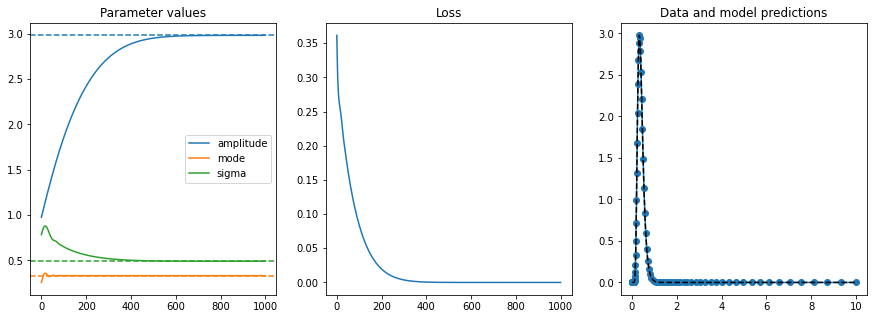

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(param_vals)
axes[0].legend(['amplitude', 'mode', 'sigma'])
axes[0].set_title('Parameter values')
for i, val in enumerate([amplitude, mode, sigma]):
    axes[0].axhline(val.item(), c=f'C{i}', linestyle='--')
axes[1].plot(losses)
axes[1].set_title("Loss")
axes[2].scatter(x, y)
axes[2].plot(x, voxel(x).detach())
axes[2].plot(x, log_gauss(x, amplitude, mode, sigma), 'k--')
axes[2].set_title("Data and model predictions")

And that's the basics of model fitting!

# With noise

Now let's add some noise to our simulated data. With this, we will no longer be able to perfectly recover the parameters, but we should still do pretty good. We'll use normally distributed noise for this.

In [31]:
amplitude, mode, sigma = 3*torch.rand(3)
print(f'{amplitude=}, {mode=}, {sigma=}')

amplitude=tensor(1.5691), mode=tensor(1.4653), sigma=tensor(1.8146)


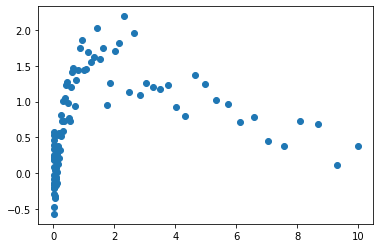

In [32]:
y = log_gauss(x, amplitude, mode, sigma)
y += .3 * torch.randn_like(y)
plt.scatter(x, y)

Everything else is the same as before. We don't need to redefine things, but let's initialize a new instance of our model, optimizer, etc

In [33]:
noisy_voxel = SingleVoxelTuning()

Note that we now have two instances of our voxel model. They're the same `type`, because they're both instances of our `SingleVoxelTuning` class, but they are independent of each other: they have different parameter values that can be varied separately.

In [34]:
print(type(voxel) == type(noisy_voxel))
print(list(voxel.named_parameters()))
print(list(noisy_voxel.named_parameters()))

True
[('amplitude', Parameter containing:
tensor([2.9798], requires_grad=True)), ('mode', Parameter containing:
tensor([0.3329], requires_grad=True)), ('sigma', Parameter containing:
tensor([0.4917], requires_grad=True))]
[('amplitude', Parameter containing:
tensor([0.4223], requires_grad=True)), ('mode', Parameter containing:
tensor([0.5648], requires_grad=True)), ('sigma', Parameter containing:
tensor([0.2091], requires_grad=True))]


Let's reinitialize our optimizer and the lists we use to track training progress

In [35]:
optim = torch.optim.Adam(voxel.parameters(), lr=1e-2,)

In [36]:
losses = []
param_vals = torch.tensor([])

In [37]:
new_params = []
pbar = tqdm(range(1000))
for i in pbar:
    # these next four lines are the core of the loop: 
    # 1. generate the prediction
    y_pred = voxel(x)
    # 2. compute the loss
    loss = obj_func(y, y_pred)
    # 3. Reset the gradients (see https://stackoverflow.com/a/48009142 for why this is necessary)
    optim.zero_grad()
    # 4. compute the gradients of the loss wrt to each parameter ("run the backwards pass")
    loss.backward()
    # 5. update all the parameters ("step the optimizer")
    optim.step()
    # these next lines are just to keep track of the loss and parameter values over time
    # .item() and .clone().detach() do the same thing -- make sure that we just get the *value*, 
    # rather than the *object* itself (which will update on each loop) (.item() only works for scalars)
    losses.append(loss.item())
    new_params.append(torch.tensor([p.item() for p in voxel.parameters()]))
    pbar.set_postfix(loss=losses[-1], params=new_params[-1], )
# turn this list of 1d tensors into one 2d tensor
param_vals = torch.concat([param_vals, torch.stack(new_params)])

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's plot the parameter values and loss over time. We can see that our paramter values are close, but not identical to the ones we initialized, and it looks like they (and the loss) have stopped changing. This means we've converged. We might be disappointed by how far off our parameter values are, but when we look at the data and predictions, we can see why: they're doing a pretty good job accounting for the data! In fact, it actually has a *lower* loss than the generating parameters! Noise does weird things.

Text(0.5, 1.0, 'Data and model predictions')

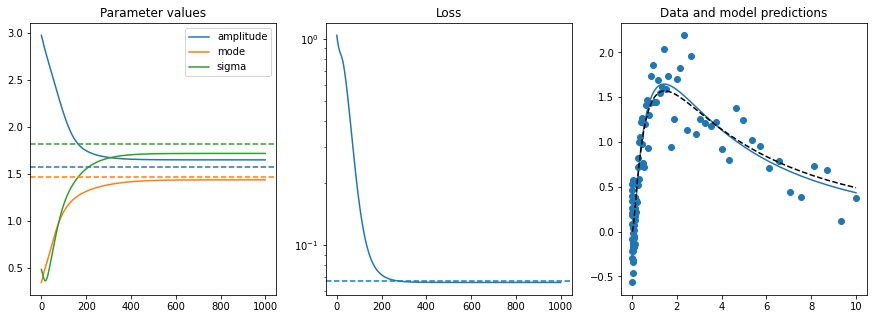

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(param_vals)
axes[0].legend(['amplitude', 'mode', 'sigma'])
axes[0].set_title('Parameter values')
for i, val in enumerate([amplitude, mode, sigma]):
    axes[0].axhline(val.item(), c=f'C{i}', linestyle='--')
axes[1].semilogy(losses)
axes[1].set_title("Loss")
axes[1].axhline(obj_func(y, log_gauss(x, amplitude, mode, sigma)), linestyle='--')
axes[2].scatter(x, y)
axes[2].plot(x, voxel(x).detach())
axes[2].plot(x, log_gauss(x, amplitude, mode, sigma), 'k--')
axes[2].set_title("Data and model predictions")

# Global parameters

the following small example shows how you can make use of pytorch's [broadcasting](https://pytorch.org/docs/stable/notes/broadcasting.html) capabilities to share two global parameters and one local parameters in the same model

for this, we'll say our model consists of two voxels, which have the same sigma and amplitude, but different modes:

In [39]:
x = torch.logspace(2, -1, 100)
amp, sigma = 3*torch.rand(2, dtype=torch.float32)
modes = 3*torch.rand(2, dtype=torch.float32)
print(f'{amp=}, {sigma=}, {modes=}')

amp=tensor(1.6891), sigma=tensor(1.5631), modes=tensor([0.8439, 1.6035])


For broadcasting to work, we need to unsqueeze the modes variable, so that it's 2d:

In [40]:
print(modes.shape)
modes = modes.unsqueeze(1)
print(modes.shape)

torch.Size([2])
torch.Size([2, 1])


Now when we call `log_gauss` with `x` (which has shape `[100]`), pytorch will automatically broadcast the shapes so that the output has shape `[2,100]`:

In [41]:
log_gauss(x, amp, modes, sigma).shape

torch.Size([2, 100])

Then when we multiply it by `x` (which has shape `[100]`), pytorch will automatically broadcast the shapes and so y has shape `[2,100]`:

torch.Size([2, 100])


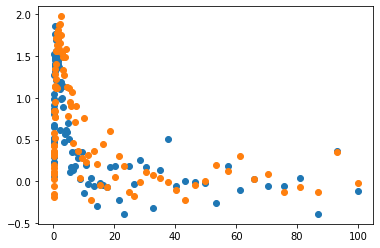

In [42]:
y = log_gauss(x, amp, modes, sigma)
y = y + .2 * torch.randn_like(y)
print(y.shape)

plt.scatter(x, y[0])
plt.scatter(x, y[1])

And that's what we have to do for our model: make sure that `self.modes` is 2d and rely on broadcasting to get the right shape:

In [45]:
class MultiVoxelTuning(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.amplitude = torch.nn.Parameter(torch.rand(1, dtype=torch.float32))
        self.modes = torch.nn.Parameter(torch.rand(2, 1, dtype=torch.float32))
        self.sigma = torch.nn.Parameter(torch.rand(1, dtype=torch.float32))

    def forward(self, x):
        return log_gauss(x, self.amplitude, self.modes, self.sigma)
    
    # you could also do this, which doesn't make use of braodcasting, to get the same result:
#     def forward(self, x):
#         data = []
#         for m in self.modes:
#             data.append(log_gauss(x, self.amplitude, m, self.sigma))
#         return torch.stack(data)

In [46]:
voxels = MultiVoxelTuning()
print(voxels(x).shape)
print(list(voxels.named_parameters()))
# note that we can use the same objective function, since it works with inputs of any shape
obj_func(y, voxels(x))

torch.Size([2, 100])
[('amplitude', Parameter containing:
tensor([0.9441], requires_grad=True)), ('modes', Parameter containing:
tensor([[0.6989],
        [0.6240]], requires_grad=True)), ('sigma', Parameter containing:
tensor([0.8223], requires_grad=True))]


tensor(0.4638, grad_fn=<MeanBackward0>)

Pytorch will automatically update the parameters correctly as we go through the training loop! We set up the optimizer the same as before:

In [48]:
optim = torch.optim.SGD(voxels.parameters(), lr=1e-2)

And then our loop is the same as before (the only difference is how we add the parameters-in-progress to `param_vals`)

In [49]:
losses = []
param_vals = {k: torch.tensor([]) for k, _ in voxels.named_parameters()}

In [355]:
torch.autograd.set_detect_anomaly(True)

In [62]:
current_params = {}
pbar = tqdm(range(1000))
for i in pbar:
    # these next four lines are the core of the loop: 
    # 1. generate the prediction
    y_pred = voxels(x)
    # 2. compute the loss
    loss = obj_func(y, y_pred)
    # 3. Reset the gradients (see https://stackoverflow.com/a/48009142 for why this is necessary)
    optim.zero_grad()
    # 4. compute the gradients of the loss wrt to each parameter ("run the backwards pass")
    loss.backward()
    # 5. update all the parameters ("step the optimizer")
    optim.step()
    # these next lines are just to keep track of the loss and parameter values over time
    # .item() and .clone().detach() do the same thing -- make sure that we just get the *value*, 
    # rather than the *object* itself (which will update on each loop) (.item() only works for scalars)
    losses.append(loss.item())
#     print(list(voxels.named_parameters()))
    for k, v in voxels.named_parameters():
        current_params[k] = v.clone().detach()
        param_vals[k] = torch.concat([param_vals[k], v.clone().detach()], -1)
    pbar.set_postfix(loss=losses[-1], **current_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's plot the parameter values and loss over time. We can see that our paramter values are close, but not identical to the ones we initialized, and it looks like they (and the loss) have stopped changing. This means we've converged.

Text(0.5, 1.0, 'Data and model predictions')

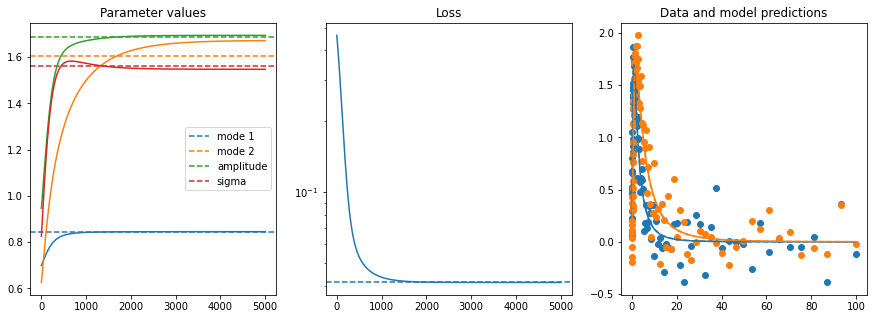

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].set_title('Parameter values')
axes[0].axhline(modes[0], c='C0', linestyle='--')
axes[0].axhline(modes[1], c='C1', linestyle='--')
axes[0].axhline(amp, c='C2', linestyle='--')
axes[0].axhline(sigma, c='C3', linestyle='--')
axes[0].legend(['mode 1', 'mode 2', 'amplitude', 'sigma'])
for k in ['modes', 'amplitude', 'sigma']:
    axes[0].plot(param_vals[k].T)
axes[1].semilogy(losses)
axes[1].set_title("Loss")
axes[1].axhline(obj_func(y, log_gauss(x, amp, modes, sigma)), linestyle='--')
axes[2].scatter(x, y[0])
axes[2].scatter(x, y[1])
for i, y_ in enumerate(voxels(x).detach()):
    axes[2].plot(x, y_, f'C{i}')
for i, y_ in enumerate(log_gauss(x, amp, modes, sigma)):
    axes[2].plot(x, y_, f'C{i}--')
axes[2].set_title("Data and model predictions")